In [27]:
%matplotlib notebook
import time
import math
import serial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from copy import deepcopy
from typing import Generator, Type
from tqdm import tqdm
from ahrs.filters import Mahony, Madgwick, Complementary
from scipy.spatial.transform import Rotation


PORT = "/dev/cu.usbserial-14240"
serialport = None

def get_imu_data():
    global serialport
    if not serialport:
        # open serial port
        serialport = serial.Serial(PORT, 115200, timeout=0.01)
        # check which port was really used
        print("Opened", serialport.name)
        
        # Flush input
        time.sleep(3)
        serialport.readline()

    # Poll the serial port
    
    # I assume, that there is some line that is not needed (empty one)
    serialport.readline()
    line = str(serialport.readline(), 'utf-8')
    if not line:
        raise ValueError('Line was not openned')
    vals = line.strip().split(',')
    if len(vals) != 9:
        raise ValueError('Lenght of values is not enough')
    try:
        vals = [float(i) for i in vals]
    except ValueError:
        raise ValueError('Values cannot be converted')
    return vals

def norm_vector(val: list[float]):
    '''
    Vetor normalisation function
    '''

    val /= np.linalg.norm(val)
    
    return val

def half_angle(angle):
    '''
    Returns cos and sin of half an angle (there is no point in it :=)
    '''

    cos_half_angle = math.sqrt((1 + math.cos(angle)) / 2)
    sin_half_angle = np.sign(math.sin(angle)) * math.sqrt(1 - cos_half_angle)
    
    return cos_half_angle, sin_half_angle

def quaternion_multiply(quaternion1, quaternion0):
    '''
    Multiplicates two quaternions
    '''

    w0, x0, y0, z0 = quaternion0
    w1, x1, y1, z1 = quaternion1
    return np.array([-x1 * x0 - y1 * y0 - z1 * z0 + w1 * w0,
                     x1 * w0 + y1 * z0 - z1 * y0 + w1 * x0,
                     -x1 * z0 + y1 * w0 + z1 * x0 + w1 * y0,
                     x1 * y0 - y1 * x0 + z1 * w0 + w1 * z0])


In [28]:
def orientation(data_source: Generator, filter_ob: Type):
    '''
    Filter list of data via certain filter
    '''

    acc_data_lst: list[tuple[float]] = []
    gyro_data_lst: list[tuple[float]] = []
    qs = []
    angles = []
        
    orientation = filter_ob()
    Q = np.array([1., 0., 0., 0.])
    
    
    for vals in data_source():
        acc_data, gyro_data, mag_data = vals[:3], vals[3:6], vals[6:]
        acc_data_lst.append(tuple(acc_data))
        gyro_data_lst.append(tuple(gyro_data))
        
        if filter_ob is FTA:
            Q = orientation.fqa(list(vals))
        else:
            Q = orientation.updateIMU(Q, acc=acc_data,gyr=gyro_data)
        try:
            rot = Rotation.from_quat(Q)
        except ValueError:
            continue
        rot_angles = rot.as_euler('xyz', degrees=True)
        rot_angles = list(rot_angles)

        # print(f'{rot_angles=}')
        qs.append(Q)
        angles.append(rot_angles)
    

    return angles

class NoneFilter:
    '''
    Integrating the gyro values (low-frequency noise example).
    Orientation from angular speed integration
    '''

    def updateIMU(self, q: np.array, gyr:np.array, acc: np.array, dt: float = 0.01):
        q = q + dt * quaternion_multiply(np.array([0., *gyr]), q) / 2

        return q
    
class FTA:
    '''
    Orientation from acceleration and magnetometer values to basis local
    vectors rotation matrix. (high-frequency noise example)
    '''

    def fqa(self, vals: list[float], local_mag: list[float] = [19.804, 2.285, 45.722]):
        '''
        Factored Quaternion Algorith (FQA)
        
        Estimates attitude of a single frame related to Earth-fixed
        frame using local magnetic field vector and acceleration vector as input.
        '''

        a_x, a_y, a_z = norm_vector(np.array(vals[:3]))
    
        sin_phi = a_x # takes the first coord
        cos_phi = math.sqrt(1 - sin_phi ** 2)
        phi = math.asin(sin_phi)
        cos_half_phi, sin_half_phi = half_angle(phi)
    
        q_y = np.array([cos_half_phi, 0.0, sin_half_phi, 0.0])
    
        sin_theta = round(- a_y / cos_phi, 2)
        cos_theta = round(- a_z / cos_phi, 2)
        theta = math.asin(sin_theta)
        cos_half_theta, sin_half_theta = half_angle(theta)
    
        q_x = np.array([cos_half_theta, sin_half_theta, 0.0, 0.0])
    
        mag_vector = np.array(vals[6:])
        local_x, local_y, _ = norm_vector(local_mag)
        x, y, _ = norm_vector(mag_vector)
    
        sin_psi, cos_psi = np.matmul([[-x, y], [-y, x]], [local_x, local_y])
        psi = math.asin(sin_psi)
        cos_half_psi, sin_half_psi = half_angle(psi)

        q_z = np.array([cos_half_psi, 0.0, 0.0, sin_half_psi])
    
        q = quaternion_multiply(quaternion_multiply(q_z, q_y), q_x)
    
        return q



def get_data_from_lst(data_lst):
    for line in data_lst:
        yield line
        

### Complementary filter realisation

In [29]:
def get_data(num_samples: int = 1000):
    data = []
    for _ in tqdm(range(num_samples)):
        data.append(get_imu_data())
    print('Collected')
    
    return data
data = get_data(100)

  0%|          | 0/100 [00:00<?, ?it/s]

Opened /dev/cu.usbserial-14240


100%|██████████| 100/100 [00:03<00:00, 29.15it/s]

Collected


In [30]:
def calibrate_data(data):
    '''
    Gyro values calibration
    '''

    min_x = min([line[3] for line in data])
    max_x = max([line[3] for line in data])
    min_y = min([line[4] for line in data])
    max_y = max([line[4] for line in data])
    min_z = min([line[5] for line in data])
    max_z = max([line[5] for line in data])
    gyro_calibration = [ (max_x + min_x) / 2, (max_y + min_y) / 2, (max_z + min_z) / 2]


    for idx, line in enumerate(data):
        line[3] += gyro_calibration[0]
        line[4] += gyro_calibration[1]
        line[5] += gyro_calibration[2]
        data[idx] = line
        
    return data

def plot(data, angle_idx: int, filter_obj: Type):
    '''
    Helper function to plot out the filtered values
    '''

    gen = partial(get_data_from_lst, data)
    angles = orientation(gen, filter_obj)
    
    df = pd.DataFrame()
    x = [elm[0] for elm in angles]
    y = [elm[1] for elm in angles]
    z = [elm[2] for elm in angles] 
    df['x'], df['y'], df['z'] = x, y, z
    df['idx'] = range(len(angles))


    for coord in ['x', 'y', 'z'][angle_idx]:
        sns.lineplot(y=coord, x='idx', data=df, label=f'{filter_obj.__name__}:{coord}')

def get_and_plot(num_samples: int, coord_idx: int):
    data = get_data(num_samples)
    data = calibrate_data(data)
    # static position filtering
    plot(deepcopy(data), 1, Mahony)
    plot(deepcopy(data), 1, Madgwick)
    plot(deepcopy(data), 1, NoneFilter)
    plot(deepcopy(data), 1, FTA)

### Static
FTA should go with -1, cause I did not pay any respect to the position of separate magnetometer sensor)

! from other tests it can be seen that though Madgewick converges, it takes some time

100%|██████████| 2000/2000 [00:28<00:00, 70.98it/s]


Collected


<IPython.core.display.Javascript object>


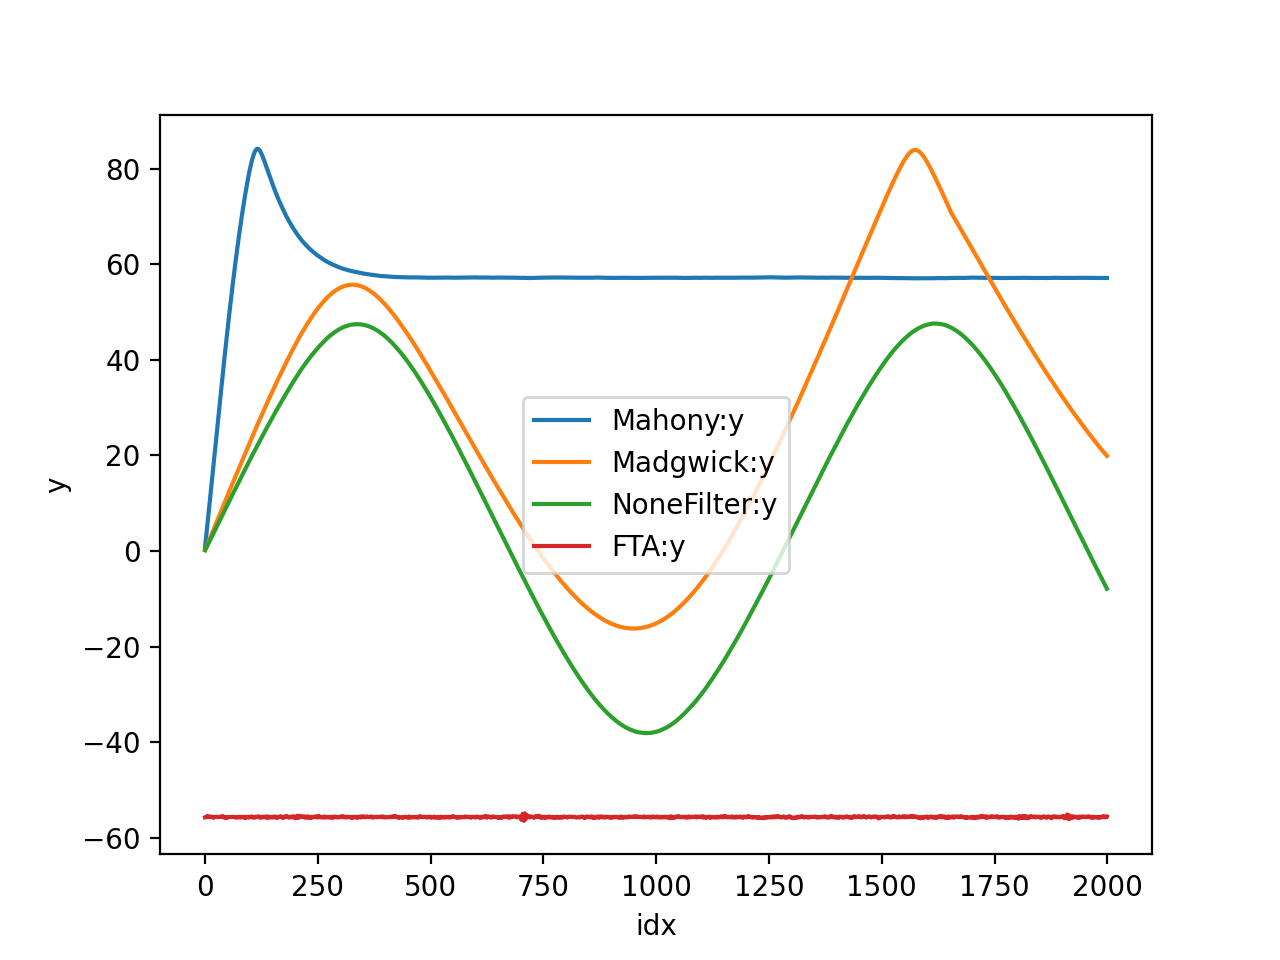

In [11]:
get_and_plot(2000, 1)

## Rotation towards me for +- 90 degrees

100%|██████████| 1000/1000 [00:12<00:00, 78.06it/s]


Collected


<IPython.core.display.Javascript object>


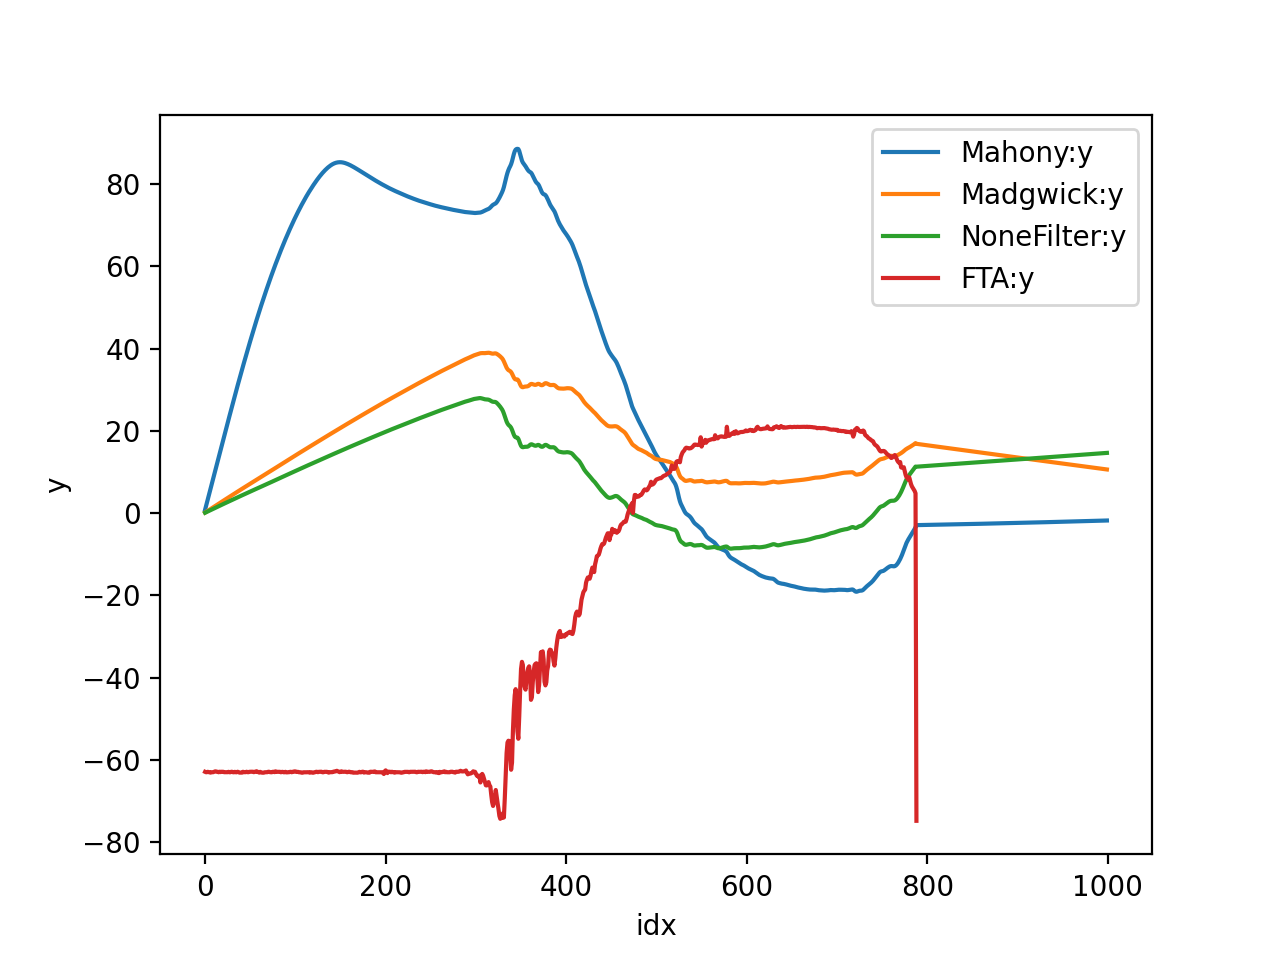

<ipython-input-27-5cbde3fd202f>:53: RuntimeWarning: invalid value encountered in true_divide
  val /= np.linalg.norm(val)


In [31]:
get_and_plot(1000, 1)

In [108]:
# qfus = k·qFQA+(1−k)·qgyro

# k is a coefficient that is dynamically calculated

# k = A(∆bias −C)+B A,B,C ∈ R (16) ∆bias = ∆mag +α∆acc α ∈ [0,1]

NORM_MAG = np.array([19.804, 2.285, 45.722])
NORM_ACC = np.array([0.0, 0.0, -9.8])

def compute_deviation(vals, for_meas: str):
    
    acc = vals[:3]
    mag = vals[6:]
    cur_quat = fqa(vals)
    conj_quat = [cur_quat[0], -cur_quat[1], -cur_quat[2], -cur_quat[3]]
    
    # does not seem completely right to me
    # check = quaternion_multiply(cur_quat, conj_quat)
    # print(f'{cur_quat=}, {conj_quat=}, {check=}')
    
    if for_meas == 'mag':
        quat = quaternion_multiply(quaternion_multiply(cur_quat, [0, *mag]), conj_quat)
    elif for_meas == 'acc':
        quat = quaternion_multiply(quaternion_multiply(cur_quat, [0, *acc]), conj_quat)
    
    return quat

def compute_k(vals, coef: float):
    '''
    k is fusion coefficient
    '''

    assert 0 < coef <= 1
    delta_mag = np.subtract(NORM_MAG, compute_deviation(vals, 'mag')[1:])
    delta_mag = norm_vector(delta_mag)
    
    delta_acc = np.subtract(NORM_ACC, compute_deviation(vals, 'acc')[1:])
    delta_acc = norm_vector(delta_acc)
    
    delta_bias = delta_mag + coef * delta_acc
    
    print(f'{delta_bias=}')
    return delta_bias

compute_k(vals, 0.5)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
delta_bias=array([0.49927144, 0.15791983, 0.35136136])


array([0.49927144, 0.15791983, 0.35136136])